<a href="https://colab.research.google.com/github/Lupama2/IntroCUDA/blob/main/ICNPG_mandelbroat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Numba for CUDA Programmers](https://github.com/numba/nvidia-cuda-tutorial)


Execution time: 0.637584


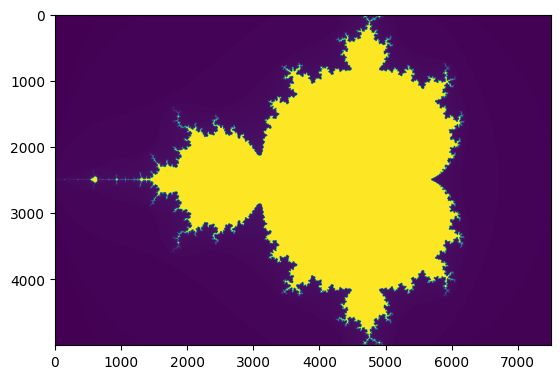

In [ ]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import print_function, division, absolute_import


from timeit import default_timer as timer

from matplotlib.pylab import imshow, show

from numba import vectorize
import numpy as np

sig = "uint8(uint32, f4, f4, f4, f4, uint32, uint32, uint32)"


@vectorize([sig], target="cuda")
def mandel(tid, min_x, max_x, min_y, max_y, width, height, iters):
    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height

    x = tid % width
    y = tid / width

    real = min_x + x * pixel_size_x
    imag = min_y + y * pixel_size_y

    c = complex(real, imag)
    z = 0.0j

    for i in range(iters):
        z = z * z + c
        if (z.real * z.real + z.imag * z.imag) >= 4:
            return i
    return 255


def create_fractal(min_x, max_x, min_y, max_y, width, height, iters):
    tids = np.arange(width * height, dtype=np.uint32)
    return mandel(
        tids,
        np.float32(min_x),
        np.float32(max_x),
        np.float32(min_y),
        np.float32(max_y),
        np.uint32(height),
        np.uint32(width),
        np.uint32(iters),
    )


def main():
    width = 500 * 10
    height = 750 * 10

    ts = timer()
    pixels = create_fractal(-2.0, 1.0, -1.0, 1.0, width, height, 20)
    te = timer()
    print("Execution time: %f" % (te - ts))

    image = pixels.reshape(width, height)
    imshow(image)
    show()


if __name__ == "__main__":
    main()

Execution time: 2.218185 seconds


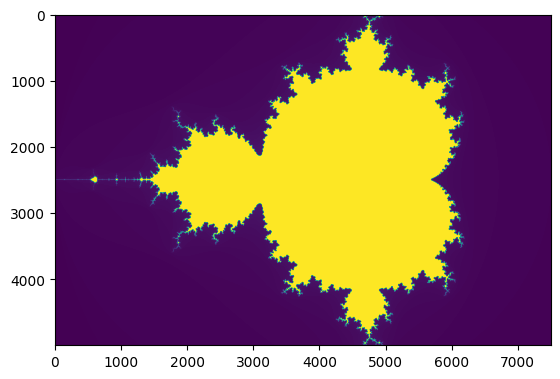

In [ ]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import print_function, division, absolute_import

from timeit import default_timer as timer
from matplotlib.pylab import imshow, show
import numpy as np

from numba import jit


@jit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z * z + c
        if (z.real * z.real + z.imag * z.imag) >= 4:
            return i

    return 255


@jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image


image = np.zeros((500 * 10, 750 * 10), dtype=np.uint8)

s = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
e = timer()
print("Execution time: %f seconds" % (e - s))

imshow(image)
show()

/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Execution time: 1.619764 seconds


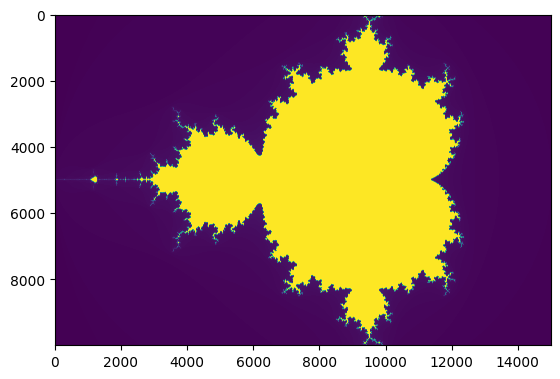

In [ ]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import print_function, division, absolute_import

from timeit import default_timer as timer
from matplotlib.pylab import imshow, show
import numpy as np

from numba import cuda


@cuda.jit(device=True)
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z * z + c
        if (z.real * z.real + z.imag * z.imag) >= 4:
            return i

    return 255


@cuda.jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height

    x, y = cuda.grid(2)

    if x < width and y < height:
        real = min_x + x * pixel_size_x
        imag = min_y + y * pixel_size_y
        color = mandel(real, imag, iters)
        image[y, x] = color


width = 15000
height = 10000
image = np.zeros((height, width), dtype=np.uint8)

pixels = width * height
nthreads = 32
nblocksy = (height // nthreads) + 1
nblocksx = (width // nthreads) + 1
s = timer()

create_fractal[(nblocksx, nblocksy), (nthreads, nthreads)](
    -2.0, 1.0, -1.0, 1.0, image, 20
)

e = timer()
print("Execution time: %f seconds" % (e - s))

imshow(image)
show()